In [1]:
!pip install transformers torch matplotlib seaborn tokenizers
# 対話的に可視化したければ（任意）
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.7 MB/s eta 0:00:00


In [2]:
# attention_viz.py
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel

In [3]:
model_name="bert-base-uncased"
text="The quick brown fox jumps over the lazy dog"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [5]:
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"]  # (1, seq_len)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Forward (get attentions)
with torch.no_grad():
    outputs = model(**inputs)
# outputs.attentions: tuple of length num_layers, each (batch, num_heads, seq_len, seq_len)
attentions = outputs.attentions

num_layers = len(attentions)
num_heads = attentions[0].shape[1]
seq_len = attentions[0].shape[-1]

In [7]:
def plot_attention_matrix(attn, tokens, title="", vmax=None, save=None):
    """
    attn: (seq_len, seq_len) numpy array
    tokens: list of token strings (len seq_len)
    """
    plt.figure(figsize=(6,6))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens,
                square=True, cbar=True, vmax=vmax)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=200)
    plt.show()

In [12]:
print(f"Model: {model_name}, layers: {num_layers}, heads: {num_heads}, seq_len: {seq_len}")
print("Tokens:", tokens)


Model: bert-base-uncased, layers: 12, heads: 12, seq_len: 11
Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '[SEP]']


* 行列の**行 i**は「クエリがトークン i のとき、どのキーに重みを払っているか（どのトークンに注目しているか）」を示します。
* 主なパターン：
  * **対角優勢（diagonal）** ：トークンが主に自分自身/近傍に注目 → 局所的処理（言語モデルでよく見る）
  * **CLS / [EOS] に集中** ：要約・文全体の文脈取得（分類タスクでの特徴）
  * **句構造に沿った注目** ：動詞が目的語を強く参照、形容詞が被修飾語を参照、など（意味的関係）
  * **ヘッド間の分業** ：あるヘッドは局所、別ヘッドは長距離関係を拾うことがある

Model: bert-base-uncased, layers: 12, heads: 12, seq_len: 11
Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '[SEP]']


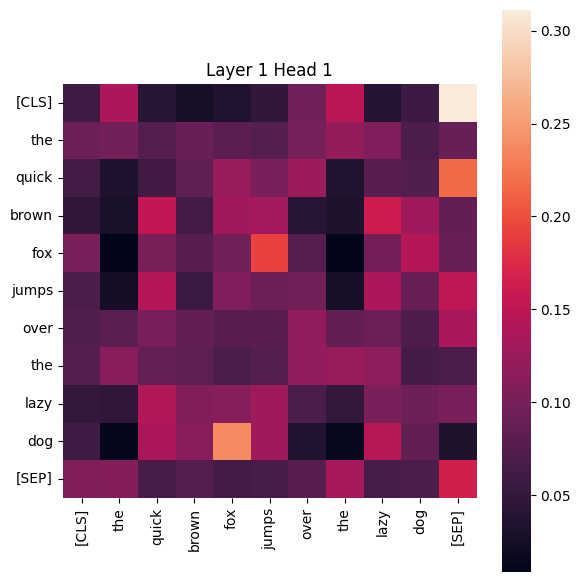

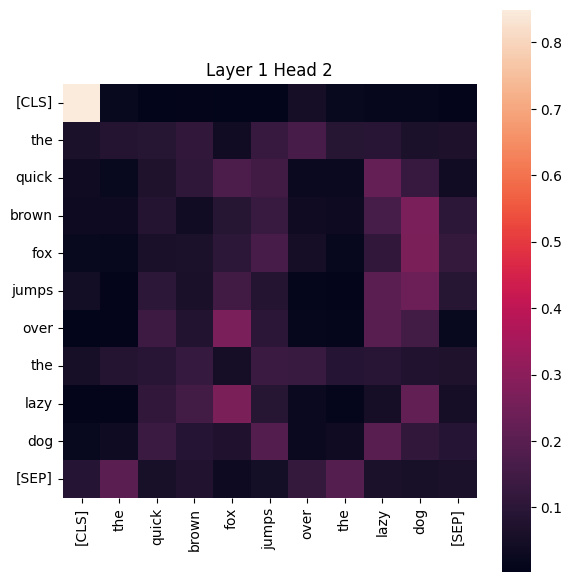

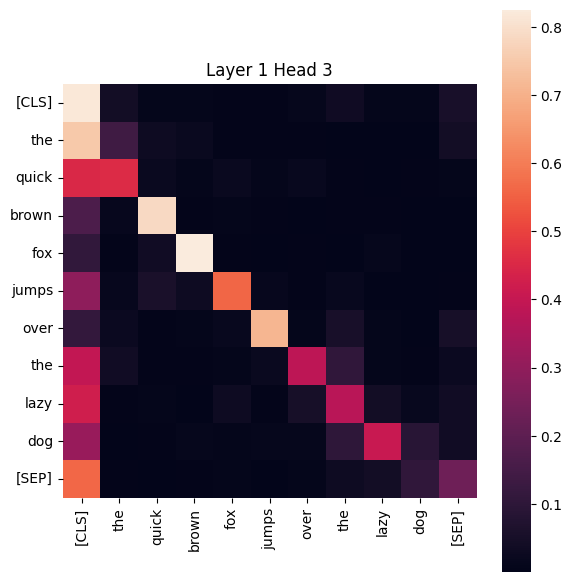

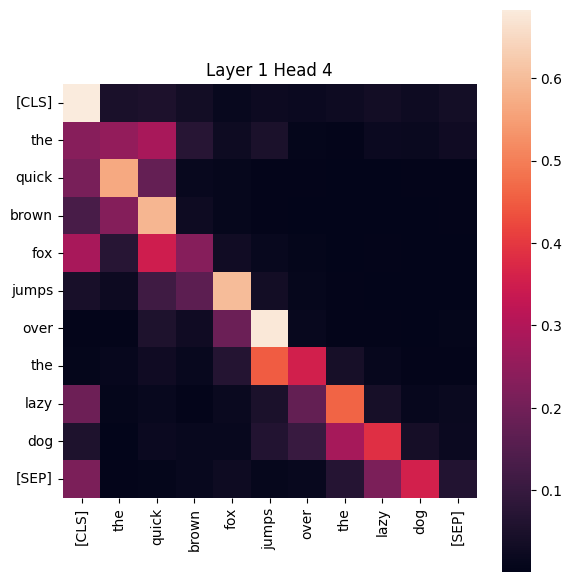

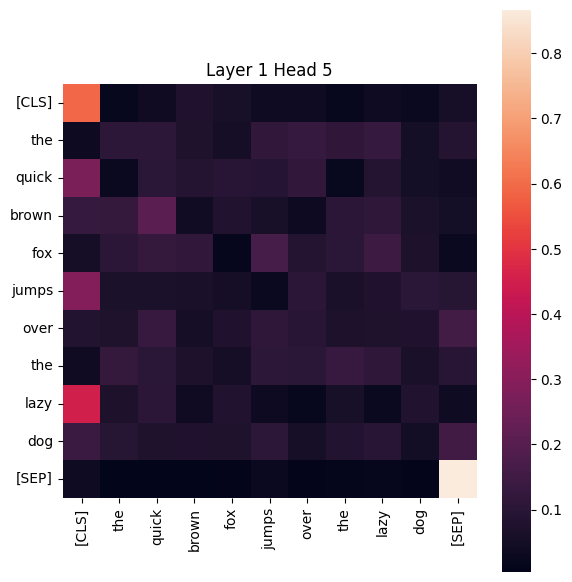

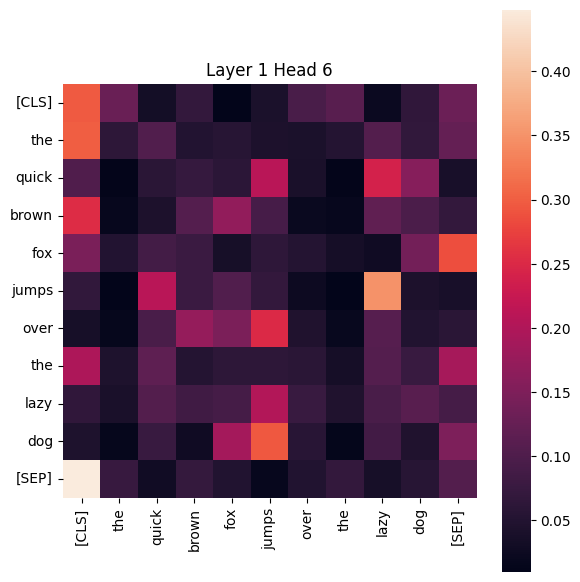

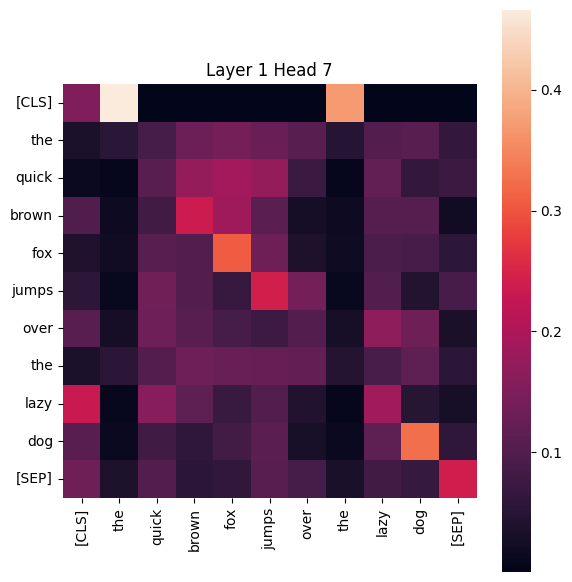

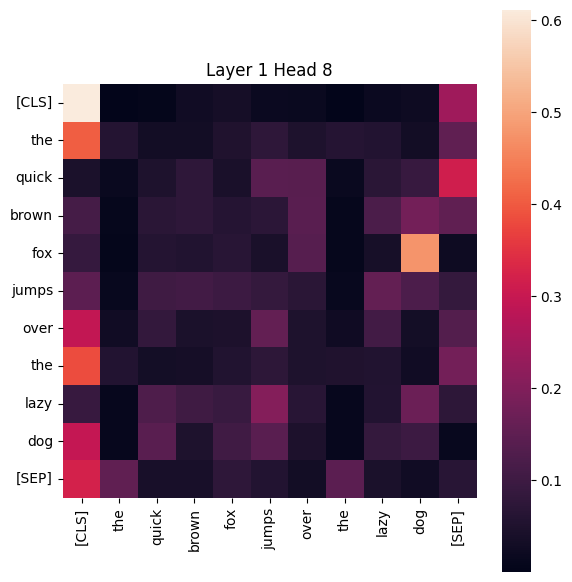

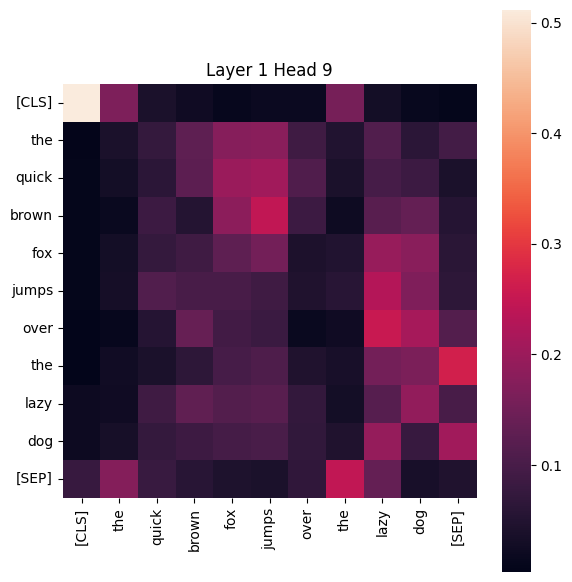

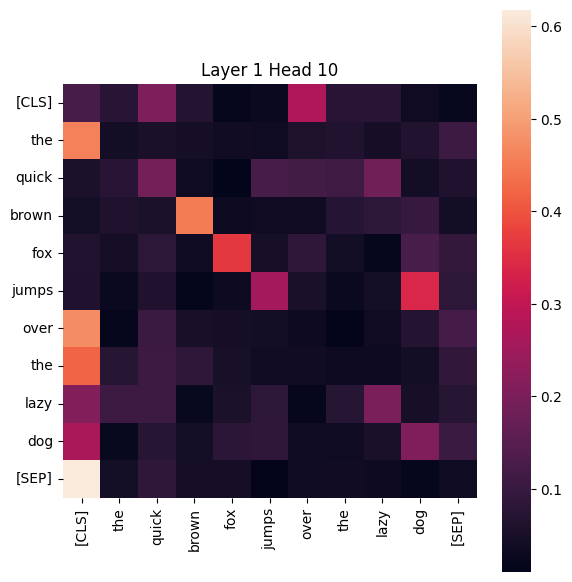

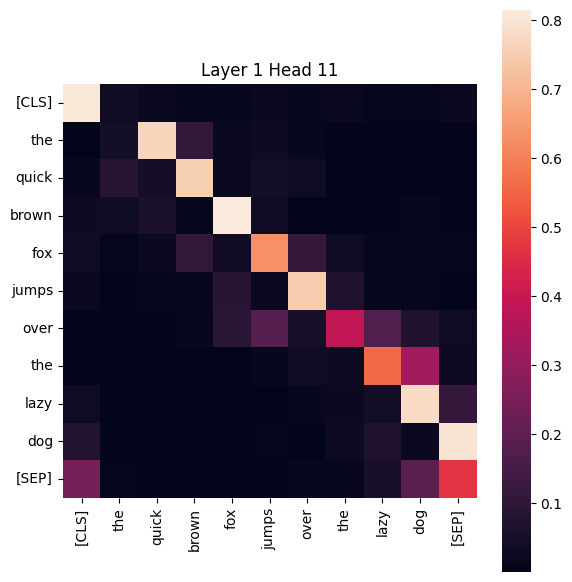

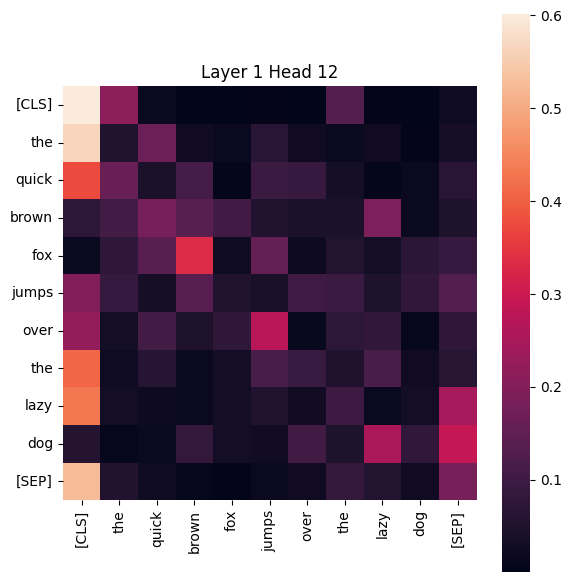

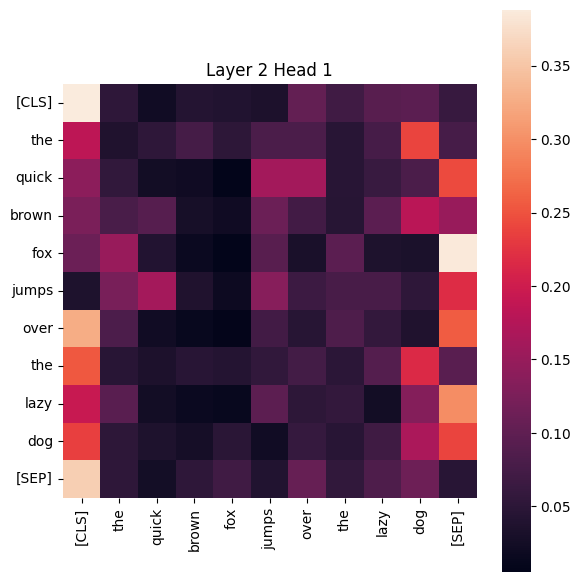

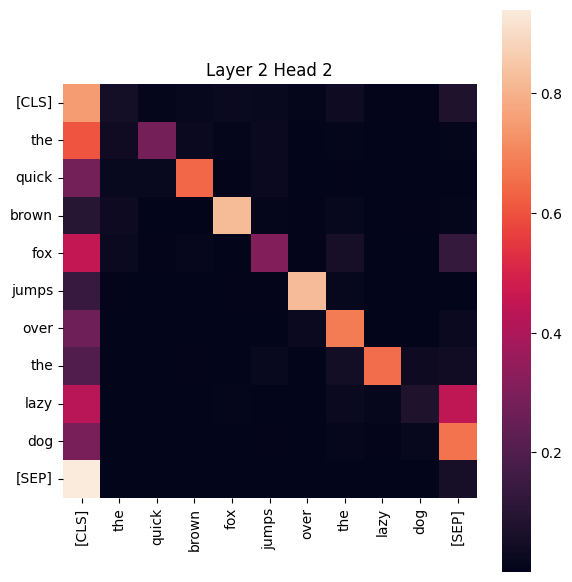

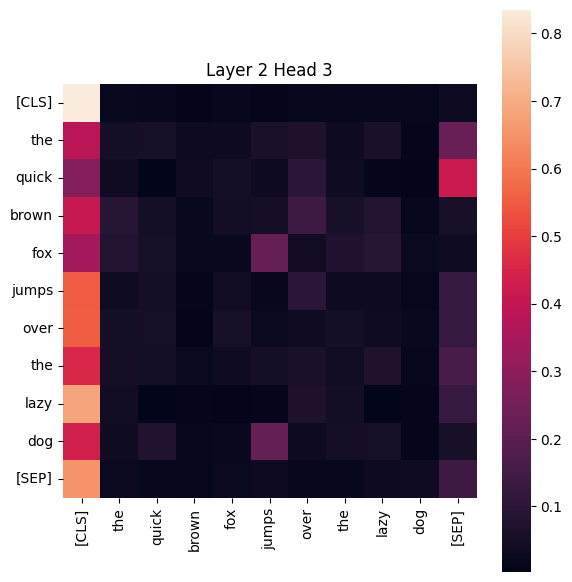

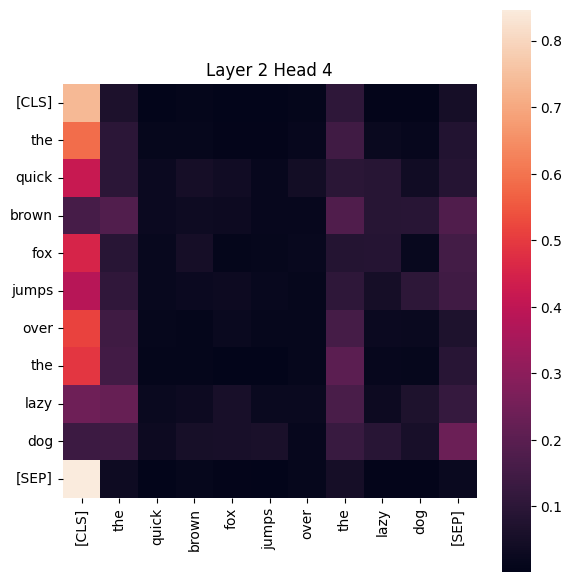

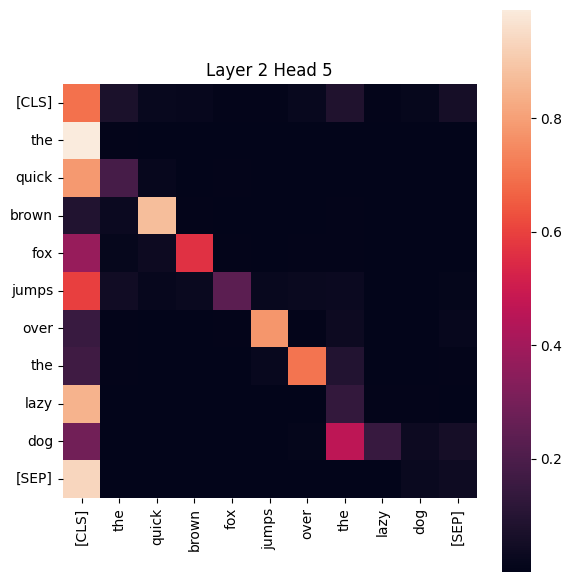

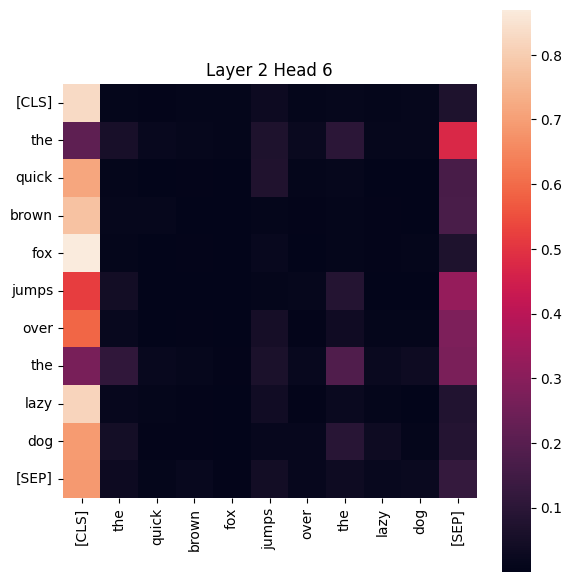

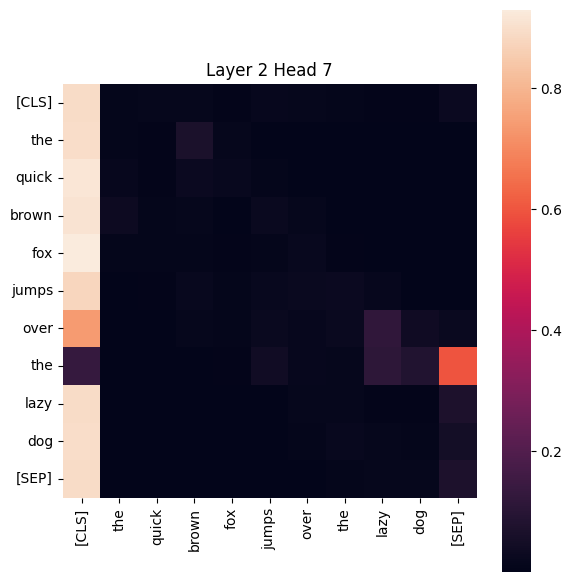

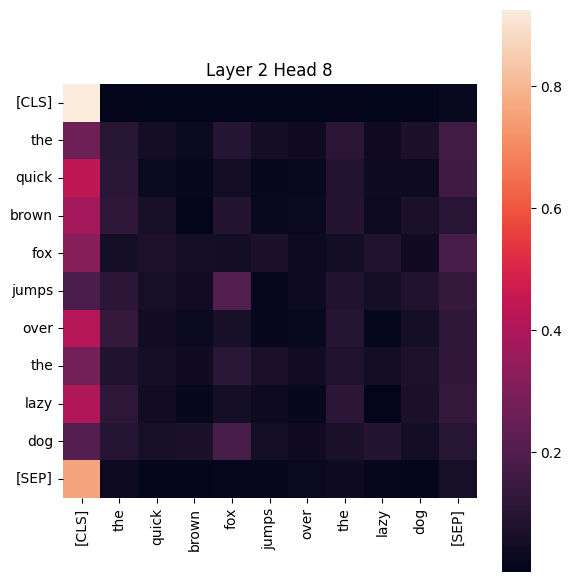

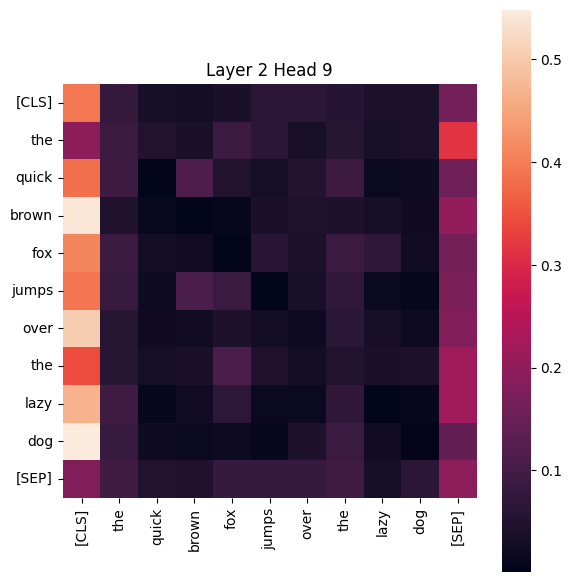

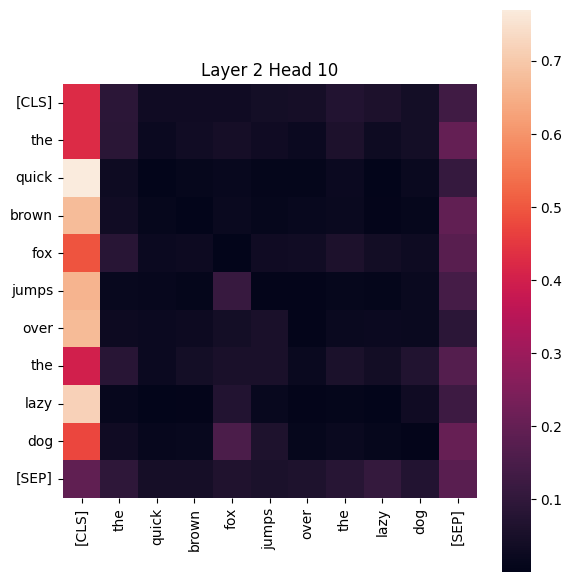

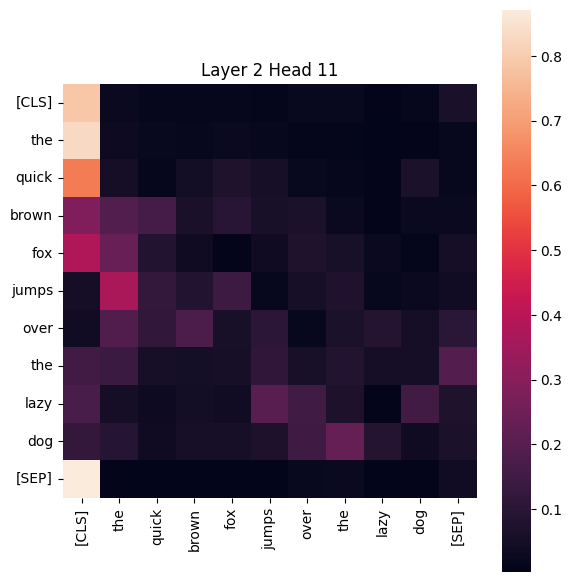

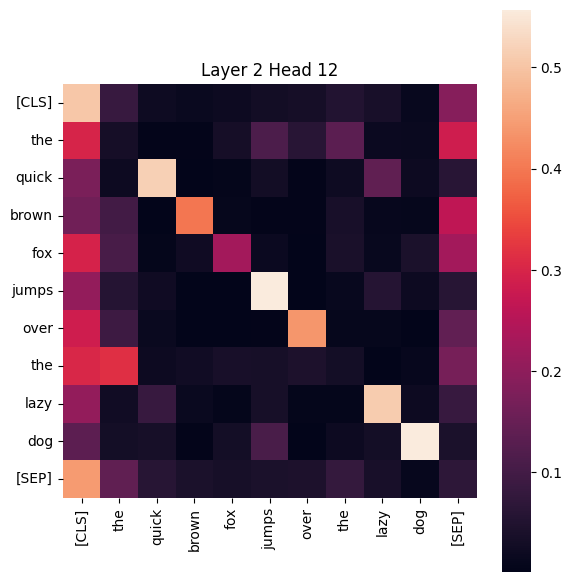

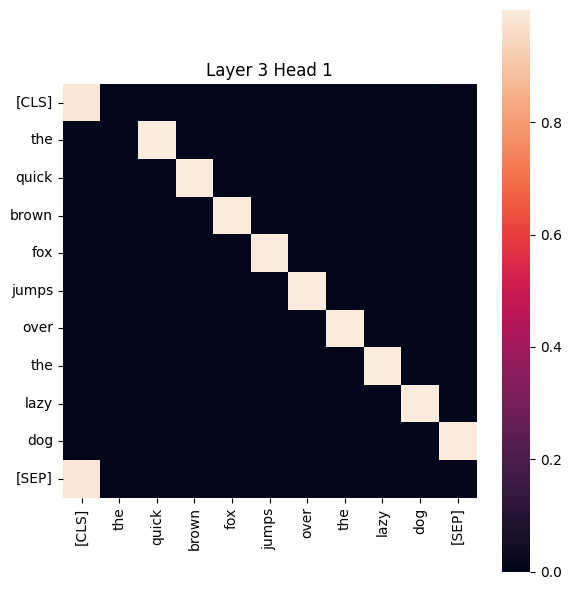

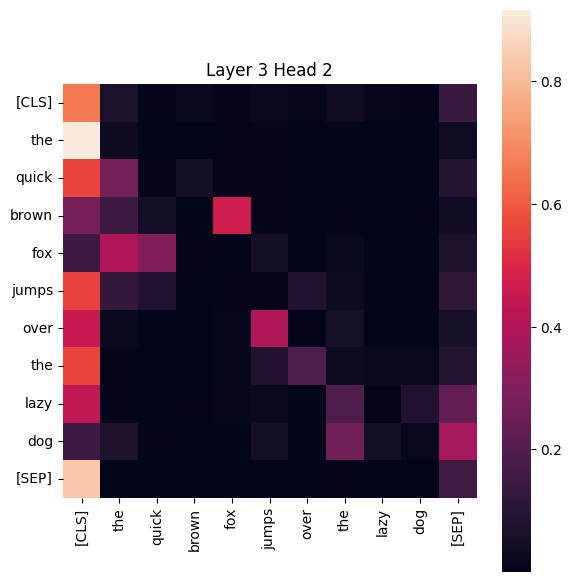

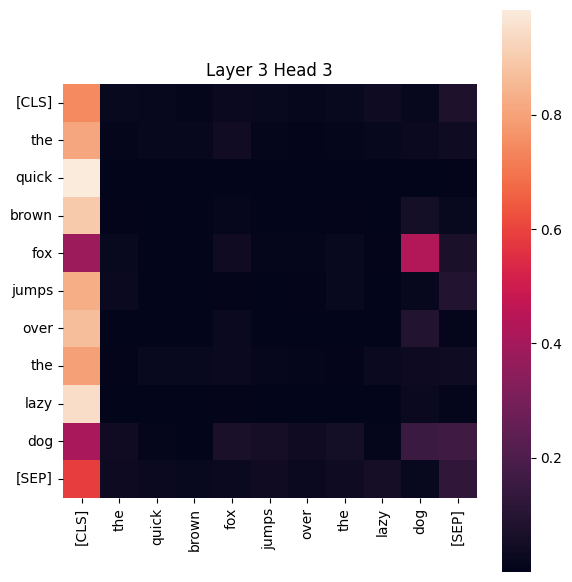

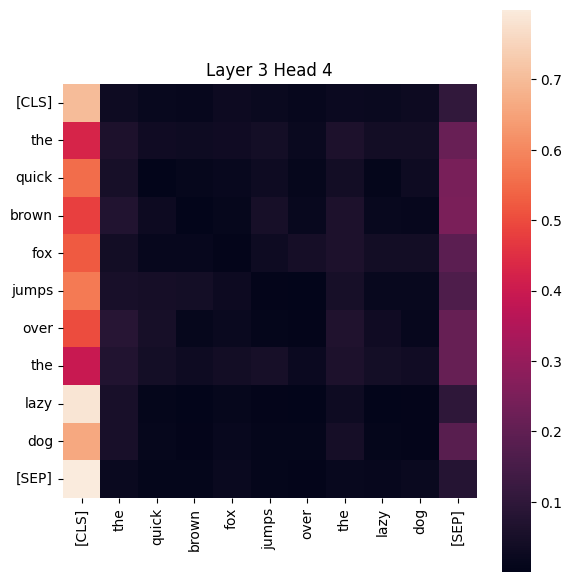

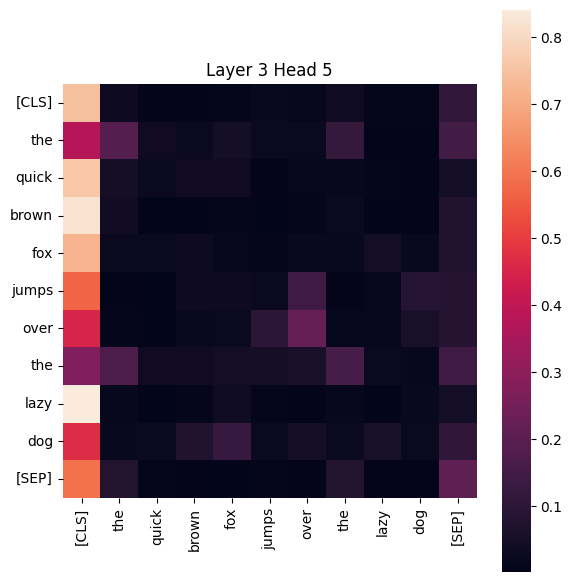

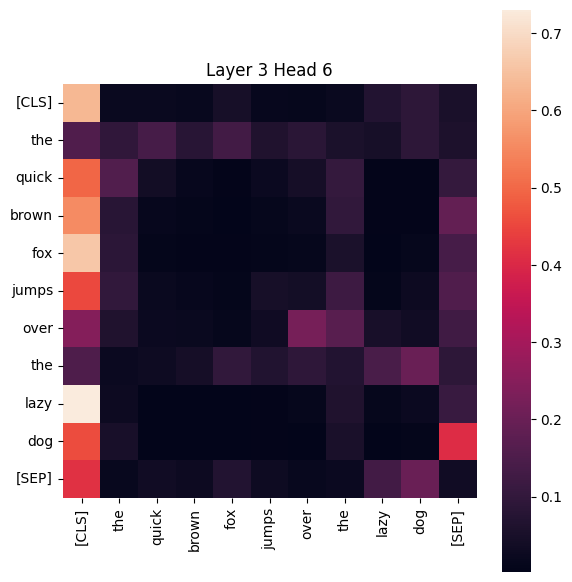

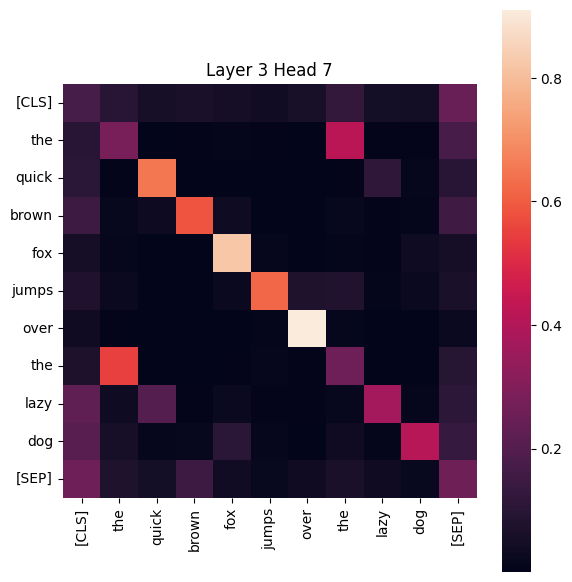

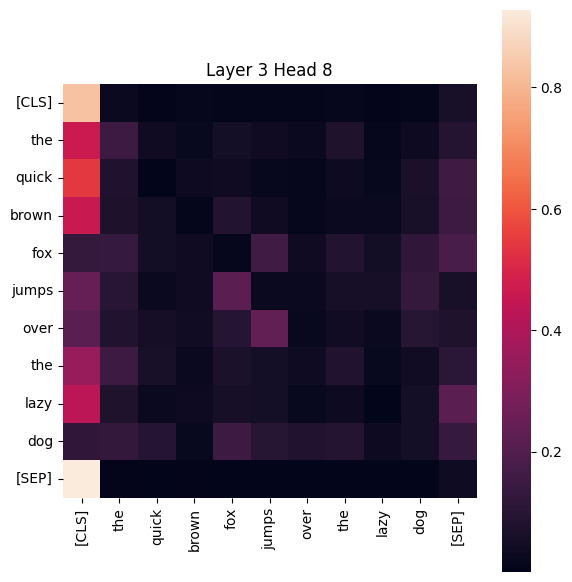

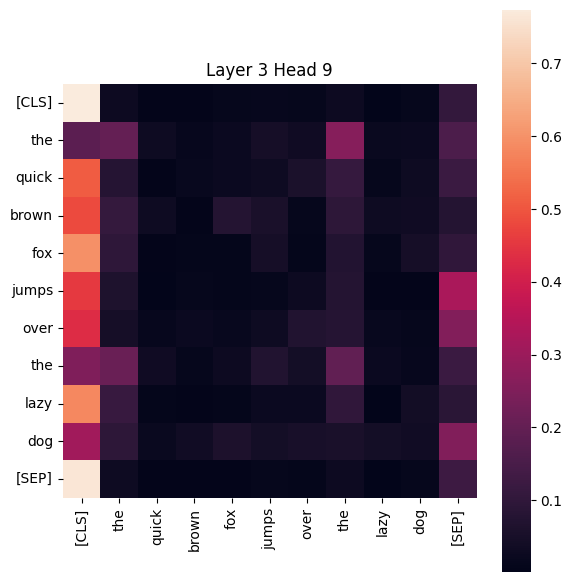

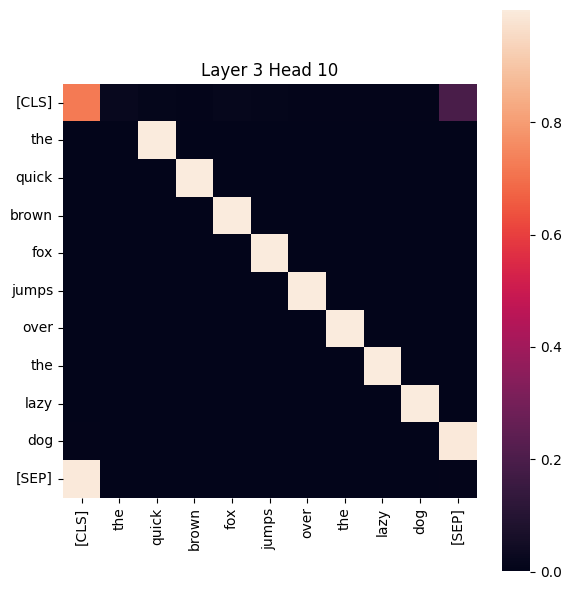

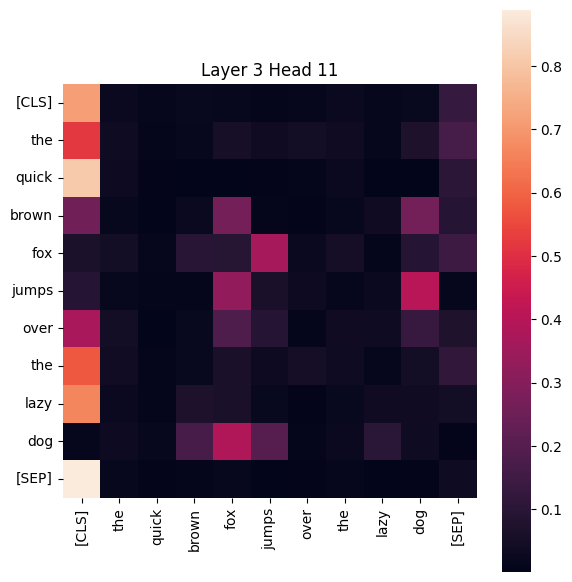

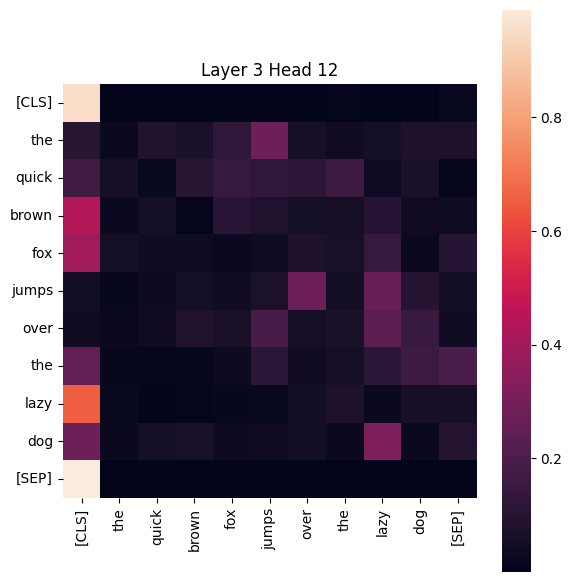

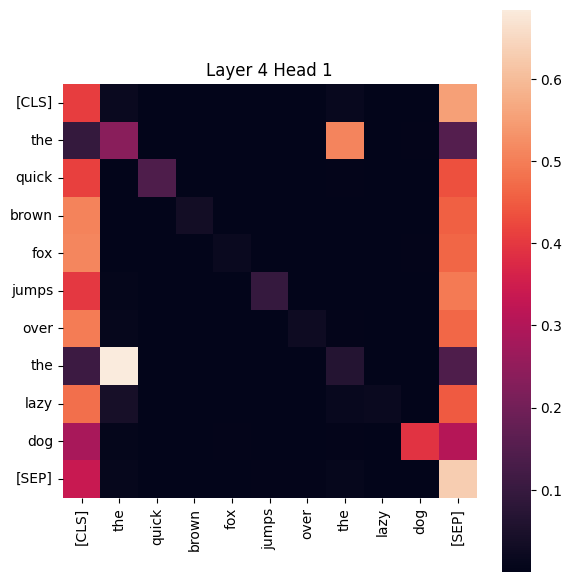

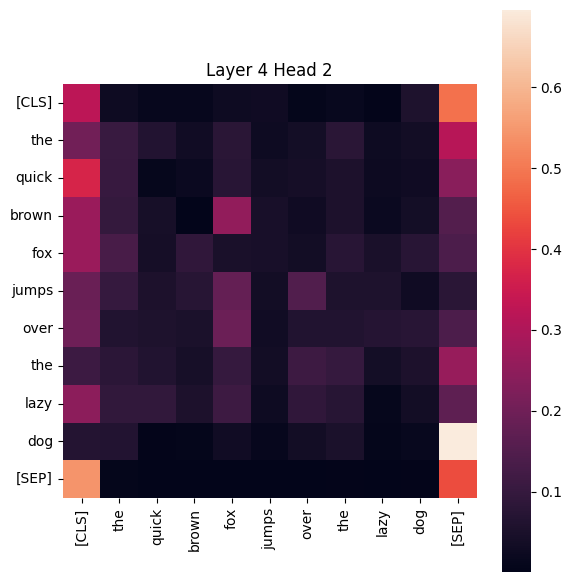

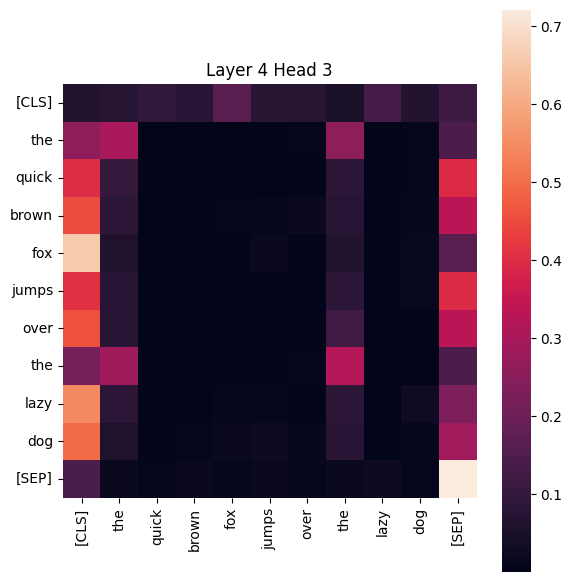

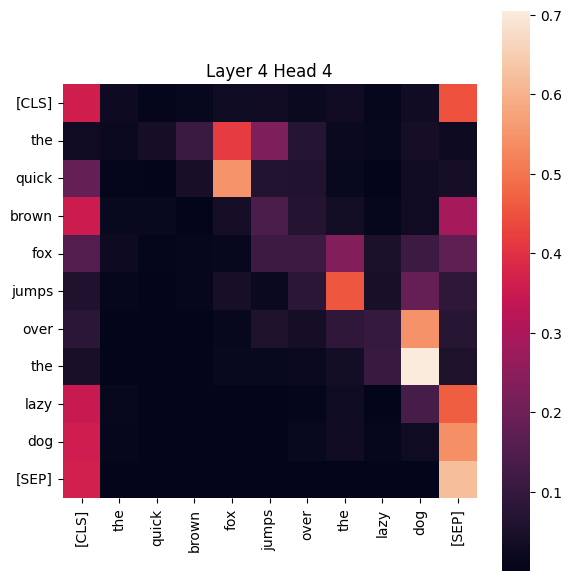

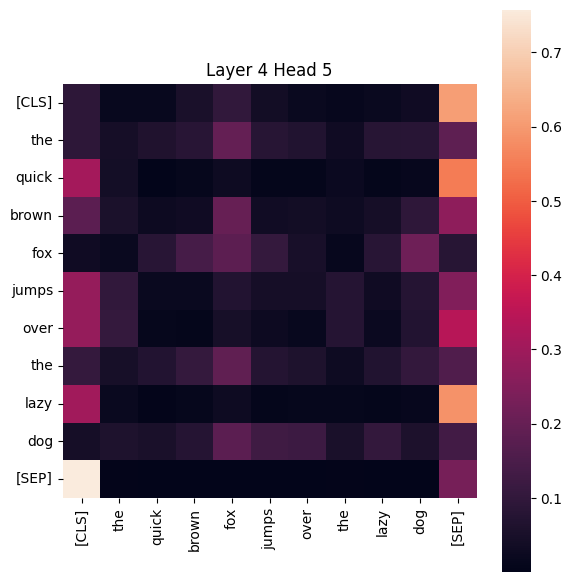

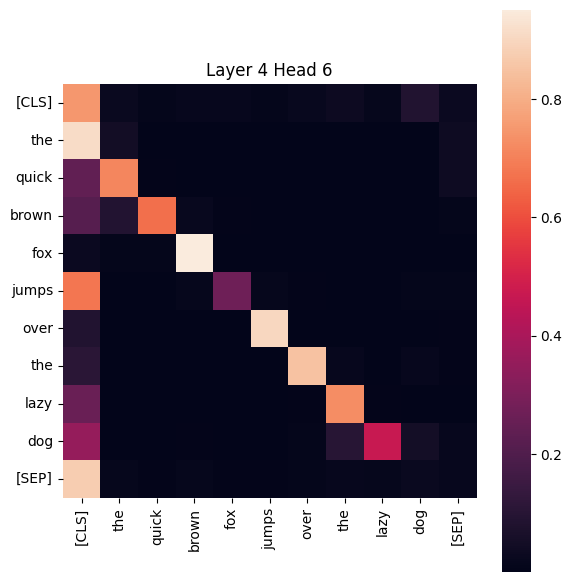

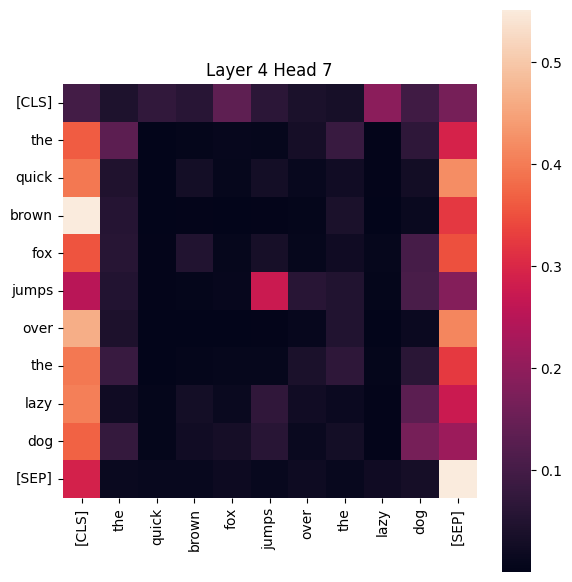

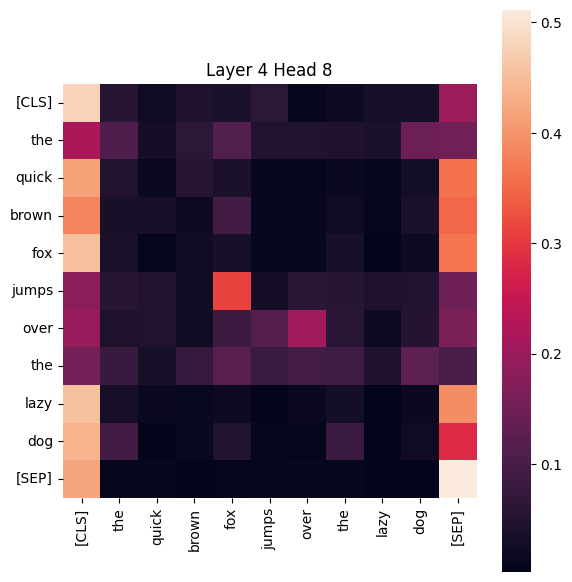

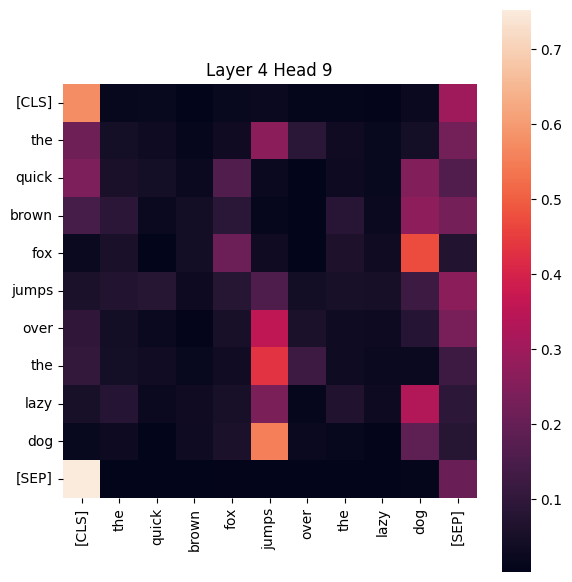

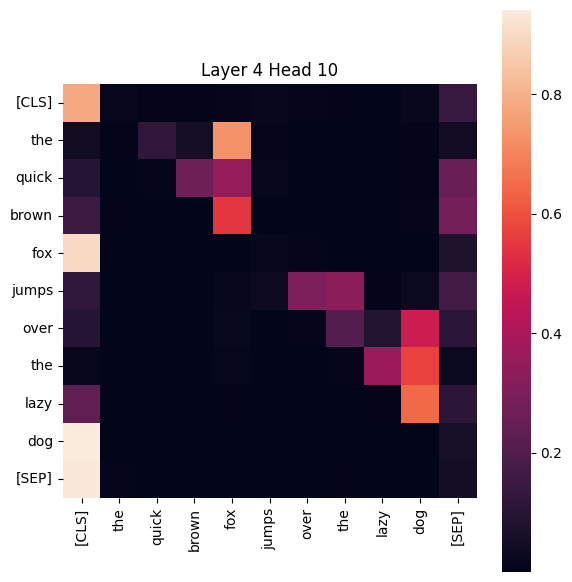

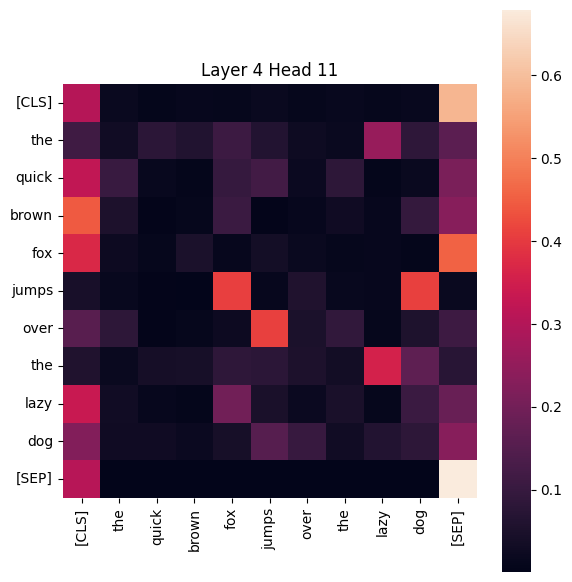

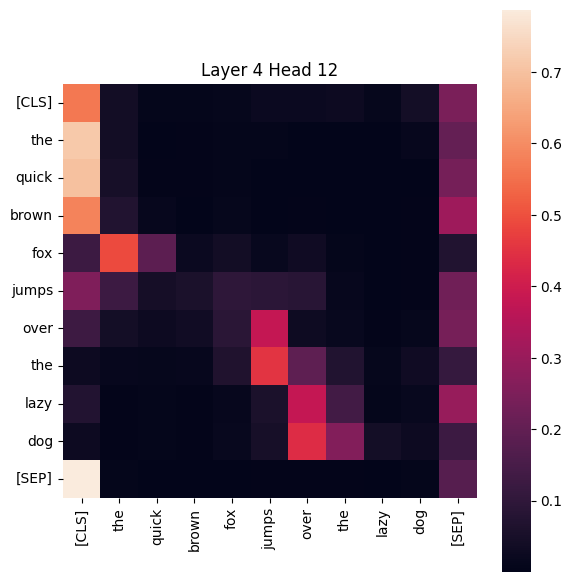

In [8]:
# Show a few heads (first layer, each head)
# You can iterate layers/heads as you like
for layer in range(min(4, num_layers)):  # show first 4 layers as demo
    for head in range(num_heads):
        mat = attentions[layer][0, head].cpu().numpy()  # (seq_len, seq_len)
        # optional normalization: already softmaxed in model -> sums to 1 across last dim
        plot_attention_matrix(mat, tokens, title=f"Layer {layer+1} Head {head+1}")

`bertviz` はトークンペアの注目をインタラクティブに探索できます（Jupyter/Colab向け）。

インストールしたら以下のパターンで簡単に可視化できます

In [11]:
from bertviz import head_view

text = "The quick brown fox jumps over the lazy dog"
inputs = tokenizer.encode_plus(text, return_tensors='pt')
outputs = model(**inputs)
attention = [att.detach().cpu() for att in outputs.attentions]
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [13]:
# 入力文
sentence = "The dog chased the cat"
inputs = tokenizer(sentence, return_tensors="pt")

# 推論実行
outputs = model(**inputs)

# 最後の層のアテンション（12層中）
attentions = outputs.attentions[-1]  # shape: [batch, heads, seq_len, seq_len]
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# 1つのヘッドを抽出して確認
import pandas as pd
head = 0
attn_matrix = attentions[0, head].detach().numpy()

pd.DataFrame(attn_matrix, index=tokens, columns=tokens)

,[CLS],the,dog,chased,the,cat,[SEP]
[CLS],0.489178,0.034699,0.016901,0.075137,0.025317,0.022122,0.336646
the,0.045054,0.054472,0.031562,0.076235,0.052218,0.042236,0.698223
dog,0.019053,0.010333,0.013109,0.024869,0.010211,0.012451,0.909974
chased,0.013410,0.003236,0.005828,0.013209,0.003058,0.010260,0.951000
the,0.033432,0.027722,0.019033,0.043069,0.026972,0.034946,0.814827
cat,0.021131,0.019679,0.010513,0.027496,0.015047,0.018746,0.887389
[SEP],0.009187,0.007134,0.005661,0.008325,0.005719,0.005798,0.958177
